In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/expedia_resampled_equal.csv')
print(df.shape)
df.head()

(100000, 24)


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-12-29 11:51:26,2,3,66,363,22020,1474.0305,119,0,1,...,0,1,8791,1,0,1,4,8,110,66
1,2014-11-25 06:52:00,2,3,66,348,48862,1545.1090,1117831,0,1,...,0,1,8791,1,0,1,4,8,110,66
2,2014-10-30 15:24:10,11,3,205,385,46963,1838.5742,72764,0,1,...,0,2,8791,1,0,1,4,8,110,66
3,2013-11-04 09:33:22,2,3,66,442,76,1032.1829,436413,0,1,...,0,1,57146,4,0,2,4,8,126,66
4,2014-09-12 16:42:31,11,3,205,155,14703,2784.4692,997831,0,0,...,0,1,8791,1,0,1,4,8,110,66


# Data Preprocessing

In [3]:
# Drop unnecessary features

df_dropped = df.copy()

df_dropped = df_dropped.drop(['date_time'], axis=1)
df_dropped = df_dropped.drop(['user_id'], axis=1)
df_dropped = df_dropped.drop(['srch_ci'], axis=1)
df_dropped = df_dropped.drop(['srch_co'], axis=1)
df_dropped = df_dropped.drop(['site_name'], axis=1)

print(df_dropped.shape)
df_dropped.head()

(100000, 19)


,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,3,66,363,22020,1474.0305,0,1,9,2,0,1,8791,1,0,1,4,8,110,66
1,3,66,348,48862,1545.1090,0,1,9,2,0,1,8791,1,0,1,4,8,110,66
2,3,205,385,46963,1838.5742,0,1,9,2,0,2,8791,1,0,1,4,8,110,66
3,3,66,442,76,1032.1829,0,1,1,2,0,1,57146,4,0,2,4,8,126,66
4,3,205,155,14703,2784.4692,0,0,3,2,0,1,8791,1,0,1,4,8,110,66


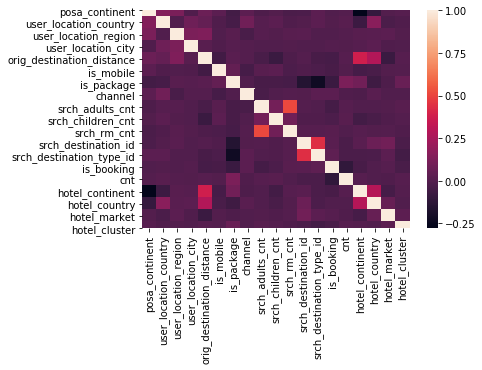

In [4]:
# Correlation heatmap
import seaborn as sns

corr = df_dropped.corr()
ax = sns.heatmap(corr)
plt.show()

In [5]:
# Get dummies for categorical features
data = pd.get_dummies(df_dropped)
print(data.shape)

(100000, 19)


In [6]:
# Separate features from target
X = data.drop(['hotel_cluster'], axis=1)
y = data['hotel_cluster']

In [7]:
# Select top K features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

n = 12
selector = SelectKBest(chi2, k=n)
X_new = selector.fit_transform(X, y)

print(X_new.shape)

(100000, 12)


In [8]:
# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25)

In [9]:
# accuracy measurements
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, log_loss, average_precision_score, scorer
import ml_metrics as metrics

def multiclass_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred)

def mean_average_precision(y_test, y_pred_proba):
    y_pred_k = np.array([
        y_pred_proba[i].argsort()[-5:][::-1] 
        for i in range(len(y_test))]) # k=5 most likely predicted classes for each input
    mAP = metrics.mapk(y_test.values[np.newaxis].T, y_pred_k, 5)
    return mAP

def evaluate(y_test, y_test_pred, y_test_pred_proba):
    accuracy = accuracy_score(y_test, y_test_pred)
    print('Accuracy', accuracy)

    #auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
    auc = multiclass_roc_auc_score(y_test, y_test_pred)
    
    #binary auc
    #auc = roc_auc_score(y_test, y_test_pred_proba[:,1])

    print('AUC', auc)

    #cross_entropy = log_loss(y_test, y_test_pred_proba)
    #print('Cross entropy', cross_entropy)
    
    # mAP@5
    mAP = mean_average_precision(y_test, y_test_pred_proba)
    print("Mean Average Precision@5", mAP)

map5 = scorer.make_scorer(mean_average_precision, needs_proba=True, greater_is_better=True)


# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [11]:
y_test_pred = knn.predict(X_test)
y_test_pred_proba = knn.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

Accuracy 0.05816
AUC 0.5243061958624511
Mean Average Precision@5 0.22511333333333333


In [12]:
# cross val to get best value for n_neighbors
from sklearn.model_selection import GridSearchCV

param_grid_knn = {
    'n_neighbors':[3,5,7,10,20,50]
}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=knn, param_grid=param_grid_knn, 
                      scoring=map5, cv=3)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 10, 20, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_average_precision, needs_proba=True),
             verbose=0)

In [13]:
print(knn_cv.best_params_)
y_test_pred = knn_cv.predict(X_test)
y_test_pred_proba = knn_cv.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

{'n_neighbors': 5}
Accuracy 0.05816
AUC 0.5243061958624511
Mean Average Precision@5 0.22511333333333333


# XGBoost

In [75]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [76]:
y_test_pred = xgb.predict(X_test)
y_test_pred_proba = xgb.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

Accuracy 0.13644
AUC 0.5633330542710241
Mean Average Precision@5 0.4526426666666667


In [77]:
# manually tune n_estimators
xgb = XGBClassifier(n_estimators=400) # best param between 300 and 500
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [78]:
y_test_pred = xgb.predict(X_test)
y_test_pred_proba = xgb.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

Accuracy 0.149
AUC 0.5697107282622317
Mean Average Precision@5 0.487004


In [79]:
# cross val to get best params for n_estimators and learning_rate

param_grid_xgb = {
    'n_estimators':[400],
    'learning_rate':[.1,.2,.3,.4]
}

xgb = XGBClassifier()
xgb_cv = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, 
                      scoring=map5, cv=3)
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'n_estimators': [400]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
print(xgb_cv.best_params_)
y_test_pred = xgb_cv.predict(X_test)
y_test_pred_proba = xgb_cv.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

In [81]:
xgb = XGBClassifier(n_estimators=400, learning_rate=0.2) # best param between 300 and 500
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [82]:
y_test_pred = xgb.predict(X_test)
y_test_pred_proba = xgb.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

Accuracy 0.15076
AUC 0.5707453345512041
Mean Average Precision@5 0.48853199999999997


# LightGBM

In [14]:
from lightgbm import LGBMClassifier

/Users/jameslu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [15]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
y_test_pred = lgb.predict(X_test)
y_test_pred_proba = lgb.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

Accuracy 0.13548
AUC 0.5631343114638953
Mean Average Precision@5 0.46021733333333337


In [73]:
# manually tune n_estimators
lgb = LGBMClassifier(n_estimators=41) # best param between 40-50
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=100, min_split_gain=0.0, n_estimators=41,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [74]:
y_test_pred = lgb.predict(X_test)
y_test_pred_proba = lgb.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

Accuracy 0.13956
AUC 0.5650638724805441
Mean Average Precision@5 0.4689626666666667


In [63]:
# cross val to get best params for n_estimators and learning_rate

param_grid_lgb = {
    'n_estimators':[35,40,45],
    'learning_rate':[.1,.2,.3]
}

lgb = LGBMClassifier()
lgb_cv = GridSearchCV(estimator=lgb, param_grid=param_grid_lgb, 
                      scoring=map5, cv=4, verbose=0)
lgb_cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         

In [64]:
print(lgb_cv.best_params_)
y_test_pred = lgb_cv.predict(X_test)
y_test_pred_proba = lgb_cv.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

{'learning_rate': 0.1, 'n_estimators': 41}
Accuracy 0.1378
AUC 0.5642803234013585
Mean Average Precision@5 0.46532


In [69]:
# tune remaining params

param_grid_lgb = {
    'num_leaves':[30,40,50,70,127],
    'min_data_in_leaf': [30, 50, 100, 300]
}

lgb = LGBMClassifier(n_estimators=41, learning_rate=.1)
lgb_cv = GridSearchCV(estimator=lgb, param_grid=param_grid_lgb, 
                      scoring=map5, cv=5, verbose=0)
lgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=41,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'min_data_in_leaf': [30, 50, 100, 300],
                    

In [70]:
print(lgb_cv.best_params_)
y_test_pred = lgb_cv.predict(X_test)
y_test_pred_proba = lgb_cv.predict_proba(X_test)
evaluate(y_test, y_test_pred, y_test_pred_proba)

{'min_data_in_leaf': 100, 'num_leaves': 30}
Accuracy 0.14044
AUC 0.5655640841085513
Mean Average Precision@5 0.46892933333333325
